##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# アテンションを用いたニューラル機械翻訳

このノートブックはTensorFlowの公式ページを基にして作られています。

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

公式ページではこの記事とは別の解説もあります。

公式ページと合わせてお読みいただくとより理解が深まります。

このノートブックでは、スペイン語から英語への翻訳を行う Sequence to Sequence (seq2seq) モデルを訓練します。
_"¿todavia estan en casa?"_  のようなスペイン語の文を入力して、英訳：  _"are you still at home?"_  を得ることができます。


Note: このサンプルは P100 GPU 1基で実行した場合に約 10 分かかります。

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## データセットのダウンロードと準備

ここでは、http://www.manythings.org/anki/ で提供されている言語データセットを使用します。このデータセットには、次のような書式の言語翻訳ペアが含まれています。

英語－スペイン語データは以下となります。

```
May I borrow this book?	¿ｿPuedo tomar prestado este libro?	CC-BY 2.0 (France) Attribution: tatoeba.org #56836 (CK) & #1677842 (teskmon)
```

なお、英語－日本語データは以下となります。

```
What time is school over?	学校は何時に終わるの？	CC-BY 2.0 (France) Attribution: tatoeba.org #9713591 (DJ_Saidez) & #10206436 (small_snow)

```



データセットをダウンロードしたあと、データを準備するために下記のようないくつかの手順を実行します。

1. それぞれの文ごとに、*開始* と *終了* のトークンを付加する
2. 特殊文字を除去して文をきれいにする
3. 単語インデックスと逆単語インデックス（単語 → id と id → 単語のマッピングを行うディクショナリ）を作成する
4. 最大長にあわせて各文をパディングする

In [2]:
# ファイルのダウンロード
!wget = 'http://www.manythings.org/anki/spa-eng.zip'
# ファイルの展開
!unzip -o spa-eng.zip
path_to_file = "/content/spa.txt"

--2023-07-09 05:21:38--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2023-07-09 05:21:38--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5359219 (5.1M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.11M  14.9MB/s    in 0.3s    

2023-07-09 05:21:39 (14.9 MB/s) - ‘spa-eng.zip’ saved [5359219/5359219]

FINISHED --2023-07-09 05:21:39--
Total wall clock time: 0.7s
Downloaded: 1 files, 5.1M in 0.3s (14.9 MB/s)
Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


最初の10行の表示

In [3]:
!head spa.txt

Go.	Ve.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)
Go.	Vete.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)
Go.	Vaya.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)
Go.	Váyase.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)
Hi.	Hola.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)
Run!	¡Corre!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)
Run!	¡Corran!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)
Run!	¡Huye!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #6714652 (arh)
Run!	¡Corra!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)
Run!	¡Corred!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005615 (Seael)


最後の10行の表示

In [4]:
!tail spa.txt

No matter how much you try to convince people that chocolate is vanilla, it'll still be chocolate, even though you may manage to convince yourself and a few others that it's vanilla.	No importa cuánto insistas en convencer a la gente de que el chocolate es vainilla, seguirá siendo chocolate, aunque puede que te convenzas a ti mismo y a algunos otros de que es vainilla.	CC-BY 2.0 (France) Attribution: tatoeba.org #939787 (CK) & #939804 (Shishir)
In 1969, Roger Miller recorded a song called "You Don't Want My Love." Today, this song is better known as "In the Summer Time." It's the first song he wrote and sang that became popular.	En 1969, Roger Miller grabó una canción llamada "Tú no quieres mi amor". Hoy, esta canción es más conocida como "En el verano". Es la primera canción que escribió y cantó que se convirtió popular.	CC-BY 2.0 (France) Attribution: tatoeba.org #552259 (American) & #1940149 (teskmon)
A child who is a native speaker usually knows many things about his or her languag

###ユニコードファイルを ascii に変換するための関数

In [5]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

### 以下の２つを行うための関数

1.  単語とそのあとの句読点の間にスペースを挿入

```
he is a boy. => he is a boy .
```

2.  文の開始(\<start\>)と終了(\<end\>)のトークンを付加

```
he is a boy .=> <start> he is a boy . <end>
```

スペイン語の場合はこちらでもOK

In [7]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 単語とそのあとの句読点の間にスペースを挿入
    # 例：　"he is a boy." => "he is a boy ."
    # 参照：- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # (a-z, A-Z, ".", "?", "!", ",") 以外の全ての文字をスペースに置き換え
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

日本語の場合は以下をインストールしてから実行


In [6]:
!pip install janome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 53.8 MB/s eta 0:00:00


In [7]:
from janome.tokenizer import Tokenizer

In [8]:
janome_tokenizer = Tokenizer(wakati=True)

In [9]:
#日本語用に改造済み
def preprocess_sentence(w):
	if re.search(r'[ぁ-ん]+|[ァ-ヴー]+|[一-龠]+', w)==None:
#	if len(w) == len(w.encode('utf-8')):
		#英語，スペイン語の場合の処理
		w = unicode_to_ascii(w.lower().strip())
		w = re.sub(r"([?.!,¿])", r" \1 ", w)
		w = re.sub(r'[" "]+', " ", w)
		w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
		w = w.rstrip().strip()

		# 文の開始と終了のトークンを付加
		# モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
		w = '<start> ' + w + ' <end>'
	else:
		#日本語の場合の処理
		print(w)
#    print(w)
		tokenized_text = janome_tokenizer.tokenize(w)
		w = ""
		for tt in list(tokenized_text):
			w = w + str(tt) + ' '
		w = '<start> ' + w + '<end>'
	return w


どのように変換されるのか試す部分
（必ずしも必要ではない）

In [10]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


### 以下の３つを行うための関数
1.   アクセント記号を除去
2.   文をクリーニング
3.   [ENGLISH, SPANISH] の形で単語のペアを返す

In [11]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

###学習データを読み込むための関数

２つ目の引数が読み込む例文数を示している。
Noneとすることですべて読み込む。

In [12]:
en, sp, lic = create_dataset(path_to_file, None)

どのように変換されるのか試す部分
（必ずしも必要ではない）

-1とすることで最後の１文を表示している。
10とすれば10行目が表示される。

In [13]:
print(en[200])
print(sp[200])

<start> he came . <end>
<start> el vino . <end>


In [14]:
print(en[30000])
print(sp[30000])

<start> i m pretty much done . <end>
<start> ya casi termino . <end>


In [15]:
print(en[-1])
print(sp[-1])

<start> one day , i woke up to find that god had put hair on my face . i shaved it off . the next day , i found that god had put it back on my face , so i shaved it off again . on the third day , when i found that god had put hair back on my face again , i decided to let god have his way . that s why i have a beard . <end>
<start> un dia , me desperte y vi que dios me habia puesto pelo en la cara . me lo afeite . al dia siguiente , vi que dios me lo habia vuelto a poner en la cara , asi que me lo afeite otra vez . al tercer dia , cuando vi que dios me habia puesto pelo en la cara de nuevo , decidi que dios se saliera con la suya . por eso tengo barba . <end>


### 読み込んだ学習データの最大の単語数（句読点も含む）を調べるための関数

In [16]:
def max_length(tensor):
    return max(len(t) for t in tensor)

### TensorFlowで扱いやすい形に変換するための関数

ここでは、最大の単語数になるように0で埋めて長さを調整しています。

例：最大の単語数が11だった場合、以下の例文は長さが足りないので、0を4つ足して入力データとします。

```
<start> i was expecting you . <end>
1 4 26 1045 6 3 2 0 0 0 0
```


In [17]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

### データを読み込んで整理するまでを1つにまとめた関数

In [18]:
def load_dataset(path, num_examples=None):
    # クリーニングされた入力と出力のペアを生成
    targ_lang, inp_lang, lic = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 実験を速くするためデータセットのサイズを制限（オプション）

100,000 を超える文のデータセットを使って訓練するには長い時間がかかります。訓練を速くするため、データセットのサイズを 30,000 に制限することができます（もちろん、データが少なければ翻訳の品質は低下します）。

In [19]:
# このサイズのデータセットで実験
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [20]:
# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


文章をIDと単語の関係として表示するための関数です。

これはどのように動作しているかを示すための関数ですので必ずしも必要ではありません。

In [21]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
    else:
      print(t)

In [22]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
2932 ----> prestame
9 ----> el
503 ----> boligrafo
3 ----> .
2 ----> <end>
0
0
0
0
0
0
0
0
0
0

Target Language; index to word mapping
1 ----> <start>
1791 ----> pass
18 ----> me
13 ----> the
378 ----> pen
3 ----> .
2 ----> <end>
0
0
0


### tf.data データセットの作成

In [23]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [24]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 10]))

## エンコーダー・デコーダーモデルの記述

### エンコーダモデル

In [25]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

エンコーダの動作を示す部分

In [26]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [27]:
example_input_batch

<tf.Tensor: shape=(64, 16), dtype=int32, numpy=
array([[   1,  492,    3, ...,    0,    0,    0],
       [   1,    8,   61, ...,    0,    0,    0],
       [   1, 2192,  769, ...,    0,    0,    0],
       ...,
       [   1,    6, 5271, ...,    0,    0,    0],
       [   1,   18, 1032, ...,    0,    0,    0],
       [   1,   27,    8, ...,    0,    0,    0]], dtype=int32)>

### アテンション

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # スコアを計算するためにこのように加算を実行する
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # スコアを self.V に適用するために最後の軸は 1 となる
    # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights の shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector の合計後の shape == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

アテンションの動作を示す部分

In [29]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


### デコーダモデル

In [30]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # アテンションのため
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output の shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # 結合したベクトルを GRU 層に渡す
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

デコーダの動作を示す部分

In [31]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4738)


## オプティマイザと損失関数の定義

In [32]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## チェックポイント（オブジェクトベースの保存）

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 訓練

1. *入力* を *エンコーダー* に通すと、*エンコーダー出力* と *エンコーダーの隠れ状態* が返される
2. エンコーダーの出力とエンコーダーの隠れ状態、そしてデコーダーの入力（これが *開始トークン*）がデコーダーに渡される
3. デコーダーは *予測値* と *デコーダーの隠れ状態* を返す
4. つぎにデコーダーの隠れ状態がモデルに戻され、予測値が損失関数の計算に使用される
5. デコーダーへの次の入力を決定するために *Teacher Forcing* が使用される
6. *Teacher Forcing* は、*正解単語* をデコーダーの *次の入力* として使用するテクニックである
7. 最後に勾配を計算し、それをオプティマイザに与えて誤差逆伝播を行う

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher Forcing - 正解値を次の入力として供給
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # Teacher Forcing を使用
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [35]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 2 エポックごとにモデル（のチェックポイント）を保存
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.0913
Epoch 1 Batch 100 Loss 2.1543
Epoch 1 Batch 200 Loss 1.9349
Epoch 1 Batch 300 Loss 1.8116
Epoch 1 Loss 2.0919
Time taken for 1 epoch 58.44439888000488 sec

Epoch 2 Batch 0 Loss 1.5854
Epoch 2 Batch 100 Loss 1.4585
Epoch 2 Batch 200 Loss 1.3935
Epoch 2 Batch 300 Loss 1.3565
Epoch 2 Loss 1.3990
Time taken for 1 epoch 27.850310802459717 sec

Epoch 3 Batch 0 Loss 1.0023
Epoch 3 Batch 100 Loss 1.1641
Epoch 3 Batch 200 Loss 0.9237
Epoch 3 Batch 300 Loss 0.9443
Epoch 3 Loss 0.9610
Time taken for 1 epoch 25.560936450958252 sec

Epoch 4 Batch 0 Loss 0.6267
Epoch 4 Batch 100 Loss 0.6796
Epoch 4 Batch 200 Loss 0.5556
Epoch 4 Batch 300 Loss 0.5690
Epoch 4 Loss 0.6361
Time taken for 1 epoch 24.354647397994995 sec

Epoch 5 Batch 0 Loss 0.4256
Epoch 5 Batch 100 Loss 0.5235
Epoch 5 Batch 200 Loss 0.4105
Epoch 5 Batch 300 Loss 0.4279
Epoch 5 Loss 0.4258
Time taken for 1 epoch 23.8517427444458 sec

Epoch 6 Batch 0 Loss 0.3395
Epoch 6 Batch 100 Loss 0.3295
Epoch 6 Batch 200 Lo

## 翻訳

* 評価関数は、*Teacher Forcing* を使わないことを除いては、訓練ループと同様である。タイムステップごとのデコーダーへの入力は、過去の予測値に加えて、隠れ状態とエンコーダーのアウトプットである。
* モデルが *終了トークン* を予測したら、予測を停止する。
* また、*タイムステップごとのアテンションの重み*を保存する。

Note: エンコーダーの出力は 1 つの入力に対して 1 回だけ計算されます。

In [36]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

### アテンションの重みをプロットする関数

In [45]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
#    ax.matshow(attention, cmap='gray')#グレースケールで表示

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#    plt.savefig('spa2eng.pdf')#画像保存用
#    plt.savefig('spa2eng.png')#画像保存用
    plt.show()

### 翻訳する文章を引数とすると翻訳結果を表示する関数

In [46]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 最後のチェックポイントを復元しテストする

In [47]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 例文でテスト

※日本語はgoogle翻訳によるものです。

### 例文1:
スペイン語
```
hace mucho frio aqui.
（ここは本当に寒いです。）
```
英語
```
it s very cold here .
（ここはとても寒いです。）
```


Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


<ipython-input-45-fa9e8ea697d6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-45-fa9e8ea697d6>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


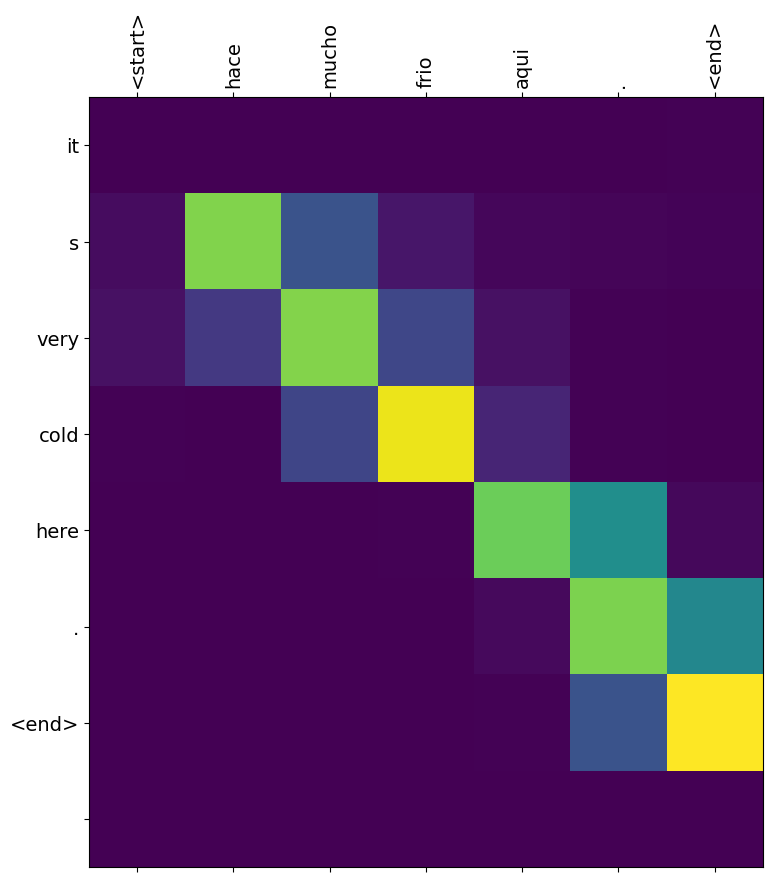

In [48]:
translate(u'hace mucho frio aqui.')

### 例文2:


スペイン語
```
esta es mi vida.
（これが私の人生です。）
```
英語
```
this is my life .
（これが私の人生です。）
```

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


<ipython-input-45-fa9e8ea697d6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-45-fa9e8ea697d6>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


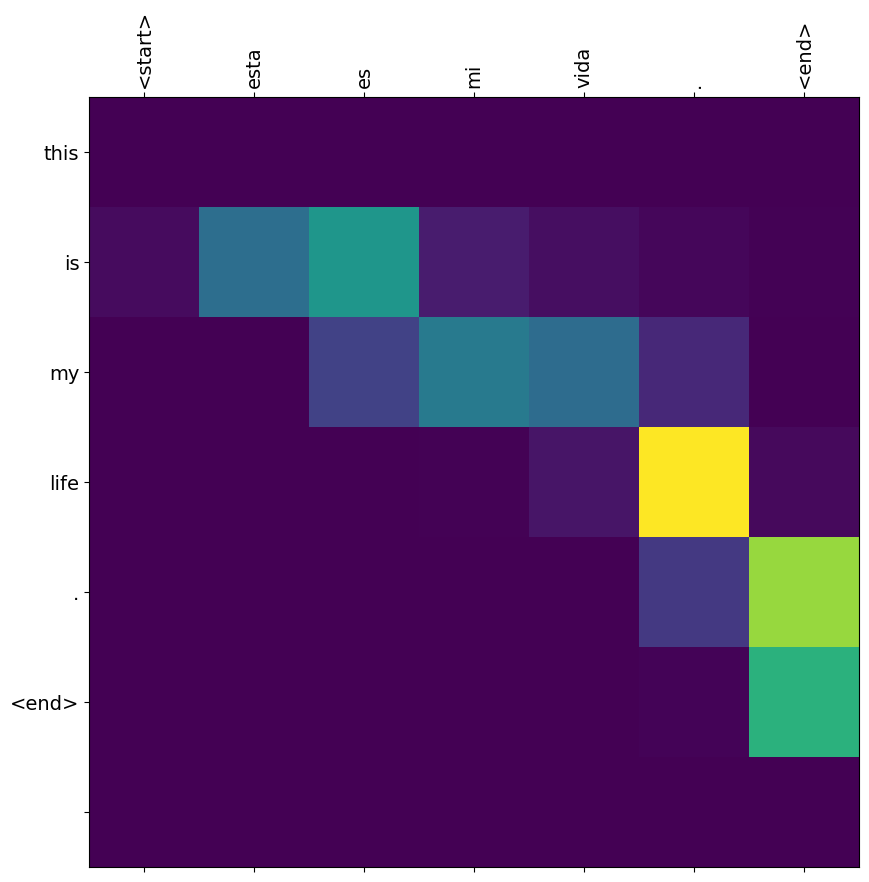

In [49]:
translate(u'esta es mi vida.')

###例文3:


スペイン語
```
¿todavia estan en casa?
（まだ家にいますか？）
```
英語
```
are you still at home ?
（あなたはまだ家にいますか？）
```

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still home ? <end> 


<ipython-input-45-fa9e8ea697d6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-45-fa9e8ea697d6>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


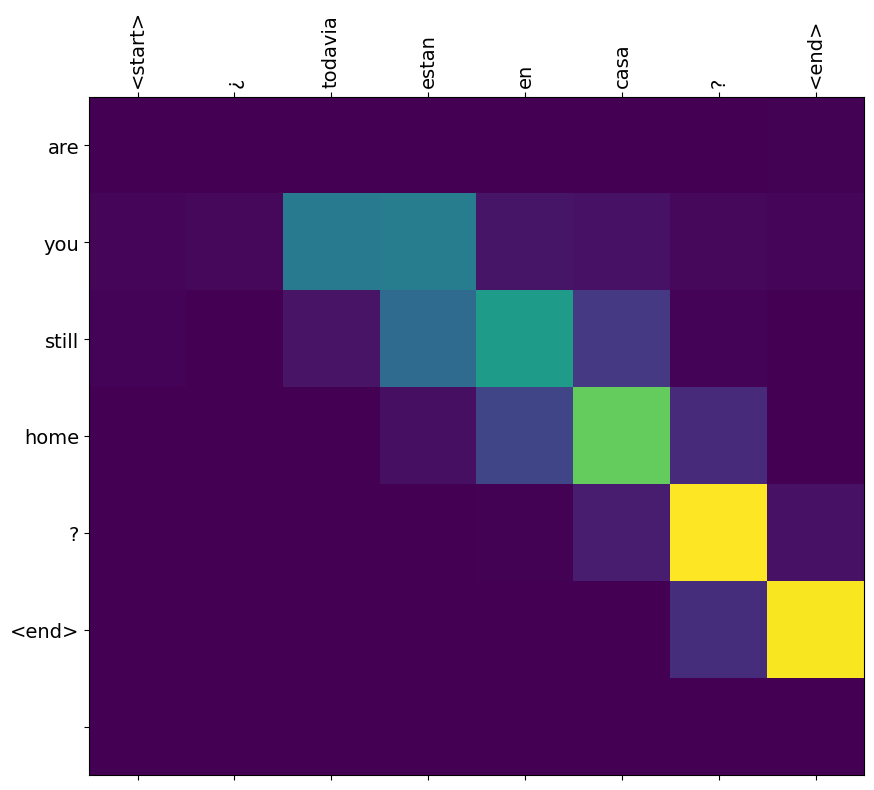

In [50]:
translate(u'¿todavia estan en casa?')

###例文4:TensorFlowの公式ホームページを使う場合は誤りとなる。


スペイン語
```
trata de averiguarlo.
（調べてみてください。）
```
英語
```
try to find out .
（調べてみてください。）
```

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to find out . <end> 


<ipython-input-45-fa9e8ea697d6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-45-fa9e8ea697d6>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


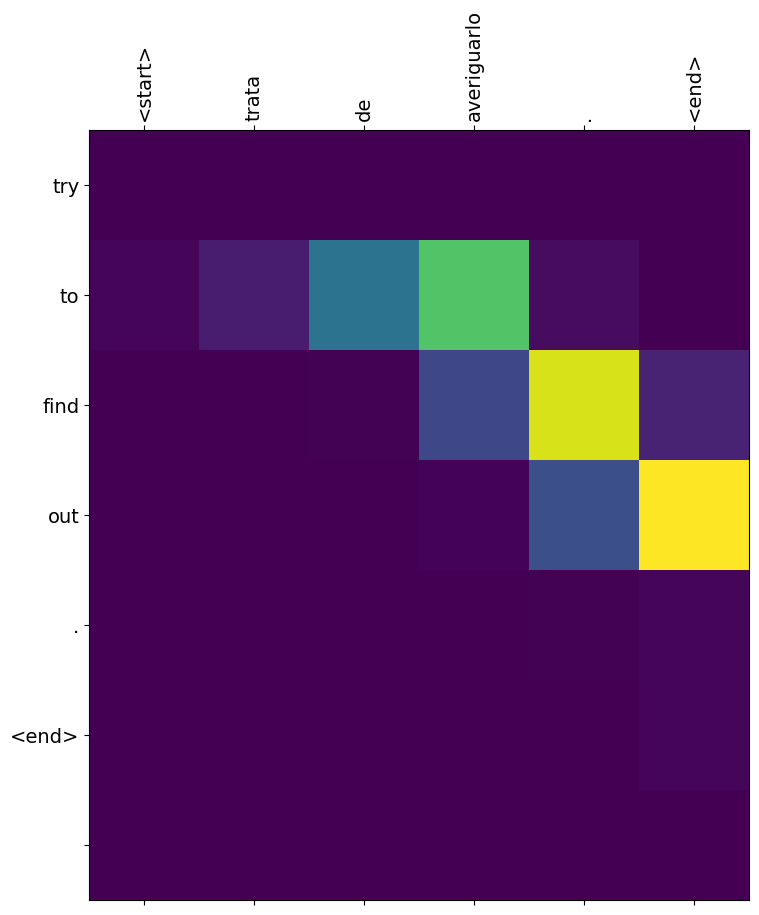

In [51]:
# TensorFlowの公式ページだと翻訳あやまりの例
# 誤り例を示すために実行できないようにしてある。# このノートブックを実行すると翻訳誤りは生じない
translate(u'trata de averiguarlo.')

###例文5:TensorFlowの公式ホームページを使う場合は誤りとなる。


スペイン語
```
trata de averiguarlo.
（調べてみてください。）
```
英語
```
try to figure it out .
（それを理解してみてください。）
```

In [52]:
# 翻訳あやまりの例
# 誤り例を示すために実行できないようにしてある。
# このノートブックを実行すると翻訳誤りは生じない
#translate(u'trata de averiguarlo.')